In [5]:
import numpy as np
import matplotlib.pyplot as plt; 
import os
import pandas as pd
import csv
import random
import time 
%matplotlib inline

Characteristic len: 0.5
Characteristic vel: 10.0
Characteristic vis: 0.025
Physical Re = 200.0
------------------------------
Dimensionless Re = 200.0
------------------------------
Time step dt = 0.0001
Space step dx = 0.01
u_lbm = 0.01
nu_lbm = 0.005
LBM Re = 200.0
------------------------------
Reynolds number = 200.0
Domain size: [10.0x0.5]
------------------------------
Mesurement points

0 : [335   7]
1 : [335   5]
2 : [335   4]
3 : [335   2]
4 : [335   1]
5 : [336   7]
6 : [336   5]
7 : [336   4]
8 : [336   2]
9 : [336   1]
10 : [337   7]
11 : [337   5]
12 : [337   4]
13 : [337   2]
14 : [337   1]
15 : [338   7]
16 : [338   5]
17 : [338   4]
18 : [338   2]
19 : [338   1]
------------------------------
Thrombus status: 0
------------------------------
Launch parameters:
	Domain size: [1000x50]
	Space step dx = 0.01
	Total time: 3.0001 sec.
	Time step dt = 0.0001
	Maximum velocity = 0.01
	Blood viscosity = 0.005
	Reynolds number = 200.0
----------------------------------------
(2,

KeyboardInterrupt: 

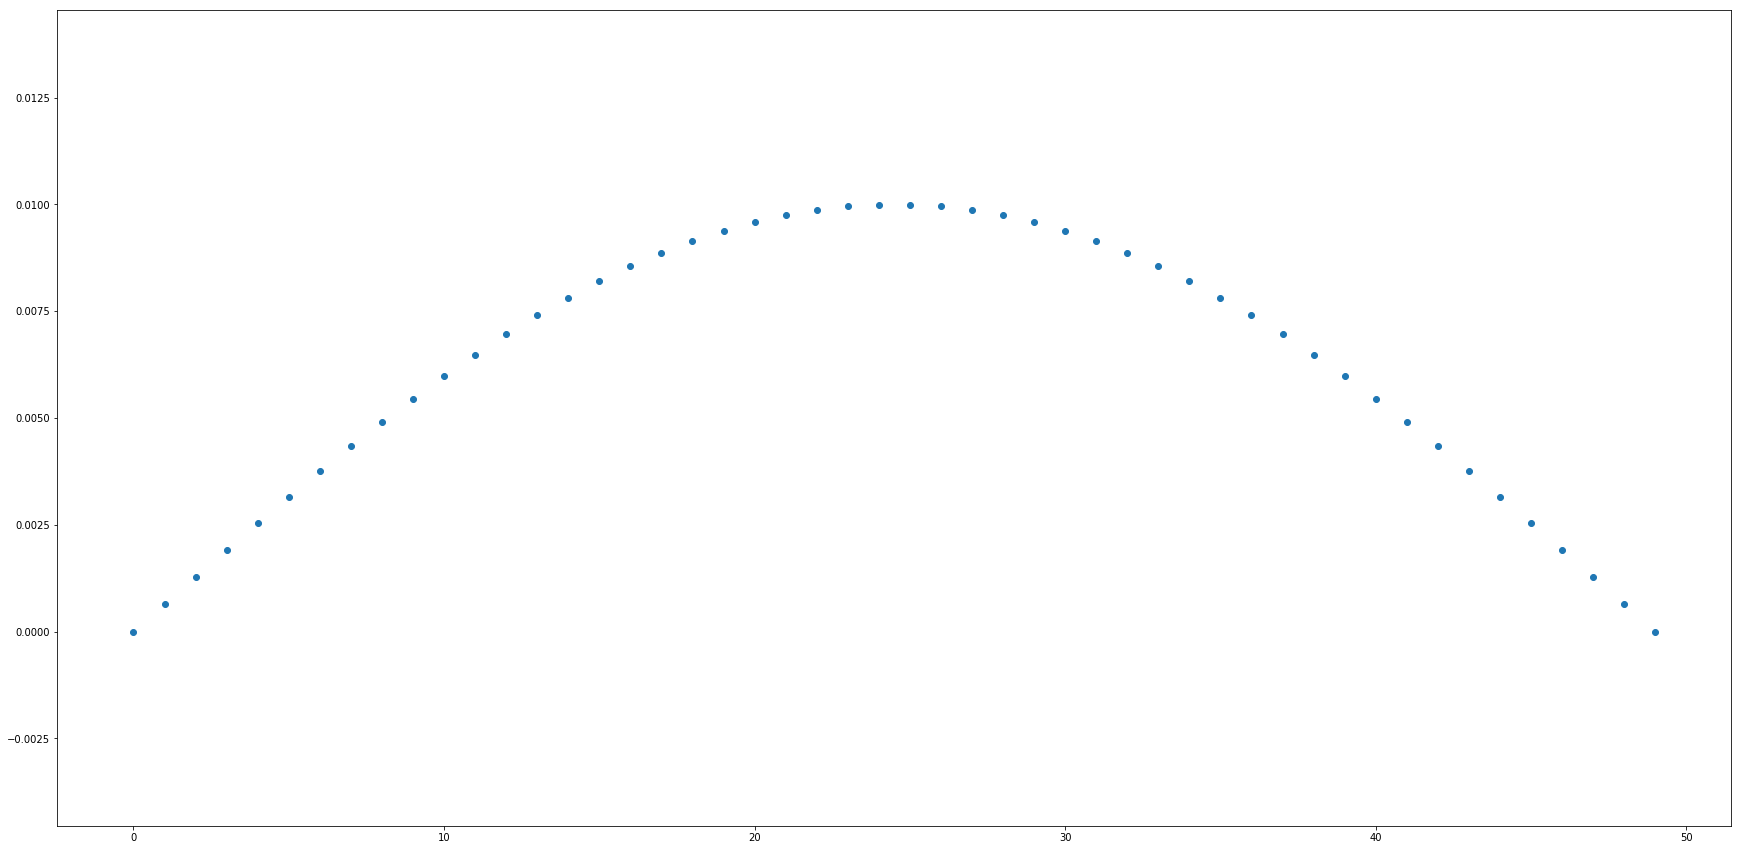

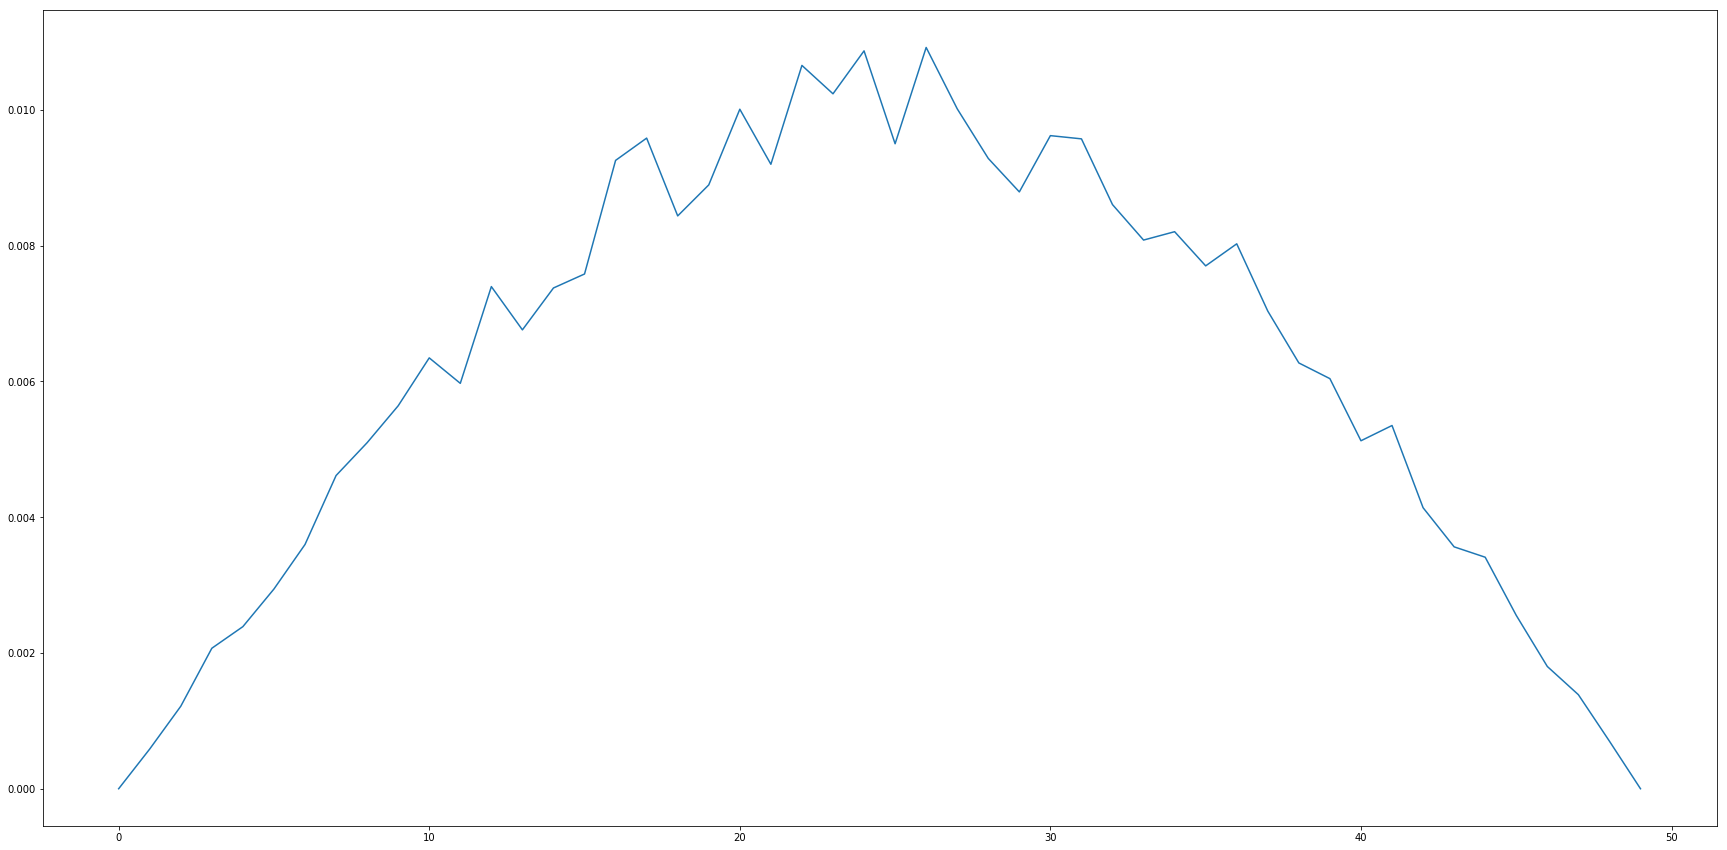

In [25]:
for ple in range(49):# Modeling domain parameters
        # Physical values
        

       # Physical values
    l_phys = 0.5
    v_phys = 10.0
    nu_phys = 2.5e-2

    print('Characteristic len: {0}'.format(l_phys))
    print('Characteristic vel: {0}'.format(v_phys))
    print('Characteristic vis: {0}'.format(nu_phys))
    print('Physical Re = ' + str(l_phys * v_phys / nu_phys))
    print('---' * 10)


        # Dimensionless values
    L0 = l_phys / 1.
    V0 = v_phys / 1.
    nu_dim = nu_phys / (L0 * V0)

    print('Dimensionless Re = ' + str(1. * 1. / nu_dim))
    print('---' * 10)





    # LBM values
    N = 100 # Number of cells on physical length l_phys
    dx = 1./N
    dt = dx**2
    u_lbm = dt/dx * 1.
    nu_lbm = dt/dx**2 * nu_dim

    print('Time step dt = {0}'.format(dt))
    print('Space step dx = {0}'.format(dx))
    print('u_lbm = {0}'.format(u_lbm))
    print('nu_lbm = {0}'.format(nu_lbm))
    print('LBM Re = {0}'.format(N*u_lbm/ nu_lbm))
    print('---' * 10)



    # Modeling domain parameters
    nx = 1000; ny = 50;
    # Obstacle (thrombus) position and radius
    cx = nx//3
    #cx = round(nx // 4);
    cy = 0; r = 1 + ple;

    # Physical parameters of blood flow
    uLB = u_lbm
    nulb = nu_lbm; 
    Re = N * uLB / nulb

    # Relaxation parameter
    omega = 1.0 / (3.* nulb + 0.5);

    # Number of discrete velocities in model (D2Q9)
    q = 9 
    # Normal directions of velocities for D2Q9 velocity template
    c = np.array([(x,y) for x in [0, -1 ,1] for y in [0, -1, 1]]) 

    # Weights for further f equilibrium calculations
    t = 1./36. * np.ones(q)
    t[np.asarray([np.linalg.norm(ci) < 1.1 for ci in c])] = 1./9.; t[0] = 4./9.

    # Opposite directions of velocities for D2Q9 velocity template
    # Necessary for No-Slip boundary condidtions implementation (bounce-back)
    noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 

    i1 = np.arange(q)[np.asarray([ci[0] <  0  for ci in c])] # Unknown on right wall.
    i2 = np.arange(q)[np.asarray([ci[0] == 0  for ci in c])] # Vertical middle.
    i3 = np.arange(q)[np.asarray([ci[0] >  0  for ci in c])] # Unknown on left wall.

    print('Reynolds number = {0}'.format(Re))
    print('Domain size: [{0}x{1}]'.format(nx*dx,ny*dx))
    print('---' * 10)




            # Helper function for density computation
    sumpop = lambda fin: np.sum(fin,axis=0) 

    # Equilibrium distribution function
    def equilibrium(rho, u):              
        cu   = 3.0 * np.dot(c, u.transpose(1, 0, 2))
        usqr = 3./ 2. * (u[0]**2 + u[1]**2)
        feq = np.zeros((q,nx,ny))
        for i in range(q): 
            feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
        return feq

    # Set Up thrombus    
    def form_tromb(obst, thr_radius):
        for x in range(cx-r-1, cx+r+1):
            for y in range(0,ny):
                if((x-cx)**2 + (y-cy)**2 < thr_radius**2):
                    obst[x,y] = True



        # For colorbar configurations
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Visualisation of modelig area
    def contour_plot(time, val, points, val_name, x_min, x_max, y_min, y_max, thr_radius):
        #fig = plt.figure(figsize = (12, 3))
        ax = plt.subplot(111)

        ax.set_xlabel(u'X-координата.', fontsize = 15)
        ax.set_ylabel(u'Y-координата.', fontsize = 15)

        x = np.arange(x_min, x_max)
        y = np.arange(y_min, y_max)

        val_tr = val.T[y_min:y_max, x_min:x_max]

        cont = plt.contourf(x, y, val_tr, cmap=plt.cm.jet) # np.arange(0.0, 0.08, 0.005)
        #cont = plt.contourf(x, y, val_tr, np.arange(0.0, 0.08, 0.005), cmap=plt.cm.jet)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        b = plt.colorbar(cont, orientation='vertical',cax=cax)

        obstacle = plt.Circle((cx, cy), thr_radius, color='k')
        ax.add_artist(obstacle)

        # print measurement points
        for pair in points:
            ax.plot(pair[0], pair[1], 'kx', mew=2, ms=5)
        plt.show()



    def streamline_plot(time, v, points, x_min, x_max, y_min, y_max, thr_radius):
        fig = plt.figure(figsize = (12, 3))
        ax = plt.subplot(111)

        ax.set_xlabel(u'X-координата.', fontsize = 15)
        ax.set_ylabel(u'Y-координата.', fontsize = 15)

        x = np.arange(x_min, x_max)
        y = np.arange(y_min, y_max)

        vx = v[0].T[y_min:y_max,x_min:x_max]
        vy = v[1].T[y_min:y_max,x_min:x_max]

        strm = plt.streamplot(x, y, vx, vy, density = [0.6, 1], linewidth=2, color='#1f77b4')  

        obstacle = plt.Circle((cx, cy), thr_radius, color='k')
        ax.add_artist(obstacle)
        # print measurement points
        for pair in points:
            ax.plot(pair[0], pair[1], 'kx', mew=2, ms=5)
        #plt.savefig('strml_{0}.png'.format(time / dt))
        #plt.show()



    top_x = cx + r + 1 # Right next to thrombus
    if r<=6:
        top_y = r+6
    else:
        top_y = r + 1
    len_x = 4 * r
    len_y = top_y
    num_p_x = 4
    num_p_y = 5

    def set_points_pos(top_x, top_y, len_x, len_y, num_p_x, num_p_y):
        if top_x + len_x > nx:
            print('Error top_x + len_x > nx')
            return

        if top_y - len_y < 0:
            print('Error top_y - len_y < 0')
            return

        x_step = len_x / num_p_x
        X = np.array([int(top_x + i * x_step)  for i in range(num_p_x)])

        y_step = len_y / num_p_y
        Y = np.array([int(top_y - i * y_step)  for i in range(num_p_y)])

        return np.array([[x,y] for x in X for y in Y])

    points = set_points_pos(top_x, top_y, len_x, len_y, num_p_x, num_p_y)

    print('Mesurement points\n')
    for i in range(len(points)):
        print('{0} : {1}'.format(i, points[i]))
    print('---' * 10)
    
    
    
    
   

    # Create folder for output dataset storage
    out_folder = 'lbm_out_data'
    #out_file_train = os.path.join(out_folder, 'lbm_train_data1.csv' )
    out_file_test = os.path.join(out_folder, 'lbm_no_pulse_Noise'+str(r)+'.csv' )
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)

    # Obtain thrombus status
    thrombus_staus = 0 # in case r <= 0.3*ny
    if r > 0.3*ny and r <= 0.6*ny:
        thrombus_staus = 1
    elif r > 0.6*ny:
        thrombus_staus = 2

    out_data = []

    print('Thrombus status: {0}'.format(thrombus_staus))
    print('---' * 10)

    
    
    # Number of iterations
    maxIter = 30001

    # Display launch parameters
    print('Launch parameters:')
    print('\tDomain size: [{0}x{1}]'.format(nx, ny))
    print('\tSpace step dx = {0}'.format(dx))
    print('\tTotal time: {0}'.format(maxIter * dt) + ' sec.')
    print('\tTime step dt = {0}'.format(dt))

    print('\tMaximum velocity = {0}'.format(u_lbm))
    print('\tBlood viscosity = {0}'.format(nu_lbm))
    print('\tReynolds number = {0}'.format(N*u_lbm/ nu_lbm))
    print('----'*10)

    # Main loop starts

    # Create obstacle
    obstacle = np.fromfunction(lambda x,y: x == -1, (nx,ny))
    # Obstacle on top and bottom boundary of modeling area
    obstacle[0:nx,0].fill(True)
    obstacle[0:nx,ny-1].fill(True)
    # Thrombus obstacle
    form_tromb(obstacle, r)

    # Input on left boundary - velocity
    vin = np.zeros((2,nx,ny))
    v_parabola_profile = np.array([uLB * np.sin(np.pi * y / (ny - 1) ) for y in range(0, ny)])
    vin[0,:,:] = v_parabola_profile

    feq = equilibrium(1.0, vin); 
    fin = feq.copy()
    # Initial distribution functions on right wall 
    # Leads to Low summary density fluctioations.
    f_last = fin[:,nx-1,:].copy()

    # Clear previous data and send trombus status
    out_data[:] = []
    out_data.append([thrombus_staus for i in range(len(points))])


    # Additional variables for PULSATILE BLOOD FLOW MODELING
    is_pulsative_blood_flow = True
    # -> Velocity change
    cur_vel_ampl = uLB
    max_vel_ampl = 2.*uLB
    vel_update_step = uLB/10.
    # Number of iterations after which we update velocity
    update_iter_count = 250
    # > 0 to increase velocity < 0 for decrease velocity
    is_increse_vel = 1.

    # Initial values for PULSATILE BLOOD FLOW
    pulsative_parabola_profile = v_parabola_profile.copy()
    feq_puls = f_last
    
    print(vin.shape,'\n\n\nfgfgfgfgfggfgfgggggg\n')
    print(vin[0,0,:],'\n\n\nfgfgfgfgfggfgfgggggg\n')
    plt.figure(1,figsize=(30,15))
    plt.scatter(range(len(vin[0,0,:])),vin[0,0,:])
    #plt.savefig('before vin.png')
    
    
    for i in range(len(vin[0,0,:])):
        vin[0,0,i] = vin[0,0,i] + vin[0,0,i]*np.random.uniform(-1,1)*0.1
    #bbbb = vin[0,0,:]*np.random.uniform(-1,1)
    #vin[0,0,:] += bbbb
    print(vin[0,0,:])
    plt.figure(2, figsize=(30,15))
    plt.plot(range(len(vin[0,0,:])),vin[0,0,:])
    plt.savefig('Pictures/after vin'+str(i)+'.png')

    start_t = time.time()
    for cur_time in range(maxIter): 
        # Macroscopic parameters update

        if is_pulsative_blood_flow and cur_time % update_iter_count == 0:
            # Decision to increase or decrease velocity amplitude
            if cur_vel_ampl >= max_vel_ampl:
                is_increse_vel = -1.
            elif cur_vel_ampl <= uLB:
                is_increse_vel = 1.

            # Update amplitude of velocity and create appropriate parabolic profile
            cur_vel_ampl += is_increse_vel * vel_update_step
            pulsative_parabola_profile = np.array([cur_vel_ampl * np.sin(np.pi * y / (ny - 1) ) for y in range(0, ny)])

            # Calculate appropriate distribution functions on left wall
            v_par = np.zeros((2,1,ny))
            v_par[0,0,:] = pulsative_parabola_profile

            feq_puls = equilibrium(1.0, v_par)[:,0,:].copy()

        # Fix distribution function values on left wall
        if is_pulsative_blood_flow:
            fin[:,0,:] = feq_puls
        else:
            fin[:,0,:] = f_last

        # Fix distribution function values on right wall    
        fin[:,nx-1,:] = f_last
        rho = sumpop(fin)
        u = np.dot(c.transpose(), fin.transpose((1,0,2))) / rho

        # Left wall: Zou/He boundary condition. 
        # Here think about velocity
        if is_pulsative_blood_flow:
            u[0,0,:] = pulsative_parabola_profile.copy()
        else:
            u[0,0,:] = vin[0,0,:]

        rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))
        feq = equilibrium(rho,u)
        fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]

        # Collision step.
        fout = fin - omega * (fin - feq)

        # No-Slip boundary conditions
        for i in range(q): 
            fout[i,obstacle] = fin[noslip[i],obstacle]

        # Streaming
        for i in range(q):
            fin[i,:,:] = np.roll(np.roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)

        # Data collecting
        if cur_time > 10000 and cur_time % 10 == 0:
            print('Current time: {0}'.format(cur_time * dt))
            print('Total dencity = {0}'.format(np.sum(rho)))

            #v = np.sqrt(u[0]**2 + u[1]**2)

            # Visualization
            #if cur_time % 500 == 0:
                #streamline_plot(cur_time, u, points, cx-4*r, cx+7*r, 0, ny, r)
                #streamline_plot(cur_time, u, points, cx-4*r, cx+7*r, 0, ny, r)
                #contour_plot(time, v, points, 'vel', cx-4*r, cx+7*r, 0, ny, r)
                #contour_plot(time, v, points, 'vel', 0, nx, 0, ny, r)

            out_data.append([rho[pair[0], pair[1]] for pair in points])

    #plt.plot(np.arange(len(lol)), lol, color = 'C0')
    plt.show()

    end_t = time.time()
    print('Elapsed time T = {0}'.format(end_t - start_t))

    # Write data for further NW calculations
    with open(out_file_test, 'a') as out:
        writer = csv.writer(out, delimiter =",", lineterminator='\n')
        for line in map(list, zip(*out_data)):
            writer.writerows([line])
        print('END iter:',lolol)
print('END all')

dfdf 0
